### Import basic libraries and load data
We will import the basic libraries that we use in every single Data Science project, these are pandas, numpy and matplotlib.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Next, we load the data. In our case we will load a dataset with Forex data with 3 years of records starting from 2018. This data includes six different currency prices with respect to the US Dollar (USD). These are also called Forex (Foreign Exchange) pairs. For this example we will focus on the Euro to Dollar pair.

Let's load the data and inspect it:

In [2]:
df = pd.read_csv('/kaggle/input/forex-data/data.csv')
df

,Date,EUR/USD,USD/JPY,GBP/USD,USD/CHF,USD/CAD,AUD/USD
0,2018-01-01,1.2010,112.66,1.3503,0.9745,1.2545,0.7805
1,2018-01-02,1.2059,112.30,1.3588,0.9716,1.2513,0.7830
2,2018-01-03,1.2014,112.50,1.3516,0.9771,1.2533,0.7836
3,2018-01-04,1.2068,112.75,1.3553,0.9746,1.2487,0.7864
4,2018-01-05,1.2030,113.08,1.3571,0.9752,1.2409,0.7864
...,...,...,...,...,...,...,...
779,2020-12-25,1.2204,103.48,1.3548,0.8889,1.2869,0.7599
780,2020-12-28,1.2214,103.78,1.3449,0.8884,1.2845,0.7577
781,2020-12-29,1.2247,103.56,1.3500,0.8843,1.2817,NaN
782,2020-12-30,1.2295,103.17,1.3622,0.8810,1.2758,0.7684


We observe some missing values, we can just fill them with the previous ones (forward fill), since it probably means that the Forex market was closed those days. Also, we notice that there are no values on the weekends, that's because of the same reason, the Forex market is closed.

In [3]:
df = df.ffill()

Next, we need to convert the date column to datetime format and set it as the index.

In [4]:
# Convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Set date as the index
df = df.set_index(['Date'])

We want all of the different currencies referenced to US Dollars, that's why we need to apply the inverse if that's not the case:

In [5]:
for pair in df.columns:
    if (pair.split('/')[0] == 'USD') & (pair.split('/')[1] != 'USD'):
        df[f"{pair.split('/')[1]}/{pair.split('/')[0]}"] = 1 / df[pair]
        df = df.drop(columns=[pair])

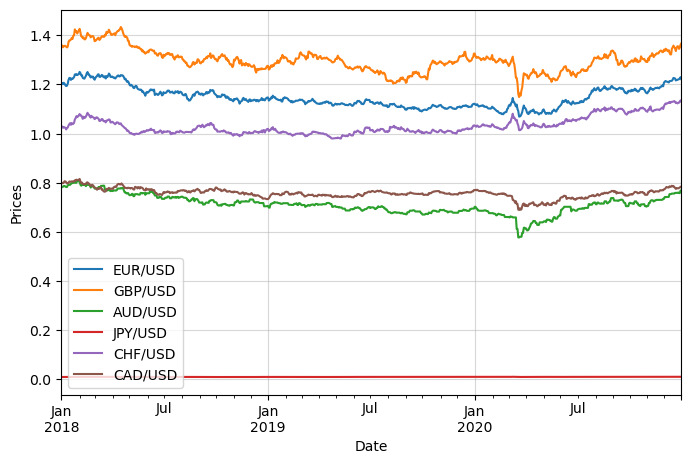

In [6]:
df.plot(figsize=(8,5))
plt.grid(alpha=0.5)
plt.ylabel('Prices')
plt.show()

We can see that the prices data is non-stationary. Also, they are not in the same scale, especially the Japanese Yen.

### Calculation of Log-Returns

So now we have the prices with respect to the US Dollar. As mentioned in previous articles, non-stationary data is not the best one when working with Time Series data. This is the main reason why prices are not used in Finance. We will calculate log returns to make time series analysis stationary:

In [7]:
df_logret = np.log(df).diff()
df_logret.dropna(inplace=True)
df_logret

,EUR/USD,GBP/USD,AUD/USD,JPY/USD,CHF/USD,CAD/USD
Date,,,,,,
2018-01-02,0.004072,0.006275,0.003198,0.003201,0.002980,0.002554
2018-01-03,-0.003739,-0.005313,0.000766,-0.001779,-0.005645,-0.001597
2018-01-04,0.004485,0.002734,0.003567,-0.002220,0.002562,0.003677
2018-01-05,-0.003154,0.001327,0.000000,-0.002923,-0.000615,0.006266
2018-01-08,-0.005251,-0.000221,-0.002929,-0.000088,-0.001946,-0.000967
...,...,...,...,...,...,...
2020-12-25,0.001476,-0.000517,0.001844,0.001449,0.001911,0.000311
2020-12-28,0.000819,-0.007334,-0.002899,-0.002895,0.000563,0.001867
2020-12-29,0.002698,0.003785,0.000000,0.002122,0.004626,0.002182


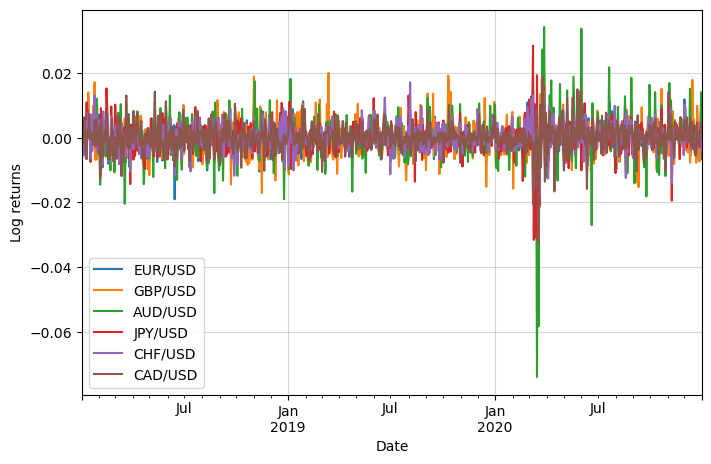

In [8]:
df_logret.plot(figsize=(8,5))
plt.grid(alpha=0.5)
plt.ylabel('Log returns')
plt.show()

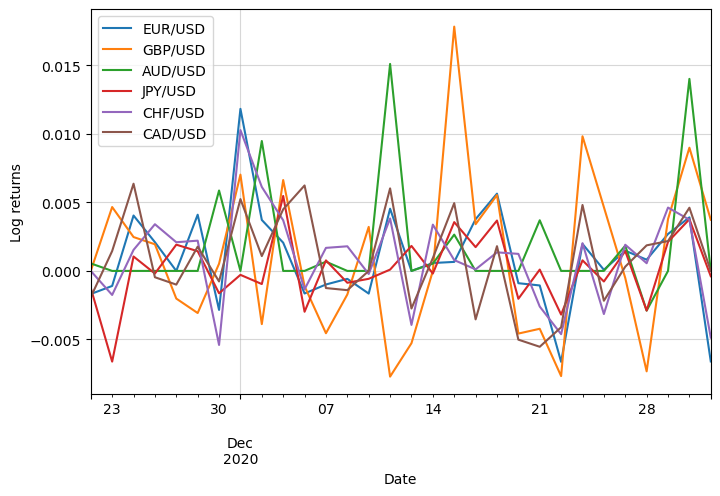

In [9]:
df_logret.iloc[-30:].plot(figsize=(8,5))
plt.grid(alpha=0.5)
plt.ylabel('Log returns')
plt.show()

We can calculate the correlation between Euro and the other currencies:

In [10]:
corr = df_logret.corr()
corr

,EUR/USD,GBP/USD,AUD/USD,JPY/USD,CHF/USD,CAD/USD
EUR/USD,1.000000,0.569307,0.283217,0.431801,0.751484,0.368293
GBP/USD,0.569307,1.000000,0.324104,0.304275,0.462511,0.418762
AUD/USD,0.283217,0.324104,1.000000,-0.003477,0.177644,0.404516
JPY/USD,0.431801,0.304275,-0.003477,1.000000,0.552559,-0.021537
CHF/USD,0.751484,0.462511,0.177644,0.552559,1.000000,0.227527
CAD/USD,0.368293,0.418762,0.404516,-0.021537,0.227527,1.000000


However, to prevent introducing noise, we will consider only those pair with a correlation higher than 0.5:

In [11]:
correlated_pairs = list(corr['EUR/USD'][1:][corr['EUR/USD'][1:] > 0.5].index)
correlated_pairs

['GBP/USD', 'CHF/USD']

We can see that the data now resembles a stationary one and all data is now in the same scale, which is what we intended to achieve.

### Reframe to a Supervised Learning problem

The idea here is to pass from a dataframe that has one column with the returns for each day (in addition to the date column or index), to a dataframe with multiple features (the X) and a target variable (the y).

We can achieve this simply by selecting a number of previous days to consider, let's say 3 previous days, and create 3 features in that initial dataframe corresponding to the returns of the three previous days:
* Features: returns corresponding to "t-1", "t-2" and "t-3".
* Target: returns corresponding to the time "t".



We can achieve that with the following function. The window size will define the number of previous returns we will consider as features.

In [12]:
def reframe_to_supervised(df:pd.Series, window_size=7, target=True, target_name=False):
    # Initialize empty dataframe
    df_supervised = pd.DataFrame()

    # Define columns names
    
    if target:
        
        if target_name:
            X_columns = [f't-{window_size-i} ({df.name})' for i in range(window_size)]
            columns = X_columns + [f'target ({df.name})']
        else:
            X_columns = [f't-{window_size-i}' for i in range(window_size)]
            columns = X_columns + ['target']
    else:
        X_columns = [f't-{window_size-i} ({df.name})' for i in range(window_size)]
        columns = X_columns

    # Iterate
    for i in range(0, df.shape[0] - window_size):
        # Extract the last "window_size" observations and target
        # value and create an individual dataframe with this info
        if target:
            df_supervised_i = pd.DataFrame([df.values[i:i+window_size+1]],
                                          columns=columns,
                                          index=[df.index[i+window_size]])
        else:
            df_supervised_i = pd.DataFrame([df.values[i:i+window_size]],
                                          columns=columns,
                                          index=[df.index[i+window_size]])
        # Add to the final dataframe
        df_supervised = pd.concat((df_supervised, df_supervised_i), axis=0)

    return df_supervised

Let's use a window of a week for the EUR/USD returns and a day for the other currencies:

In [13]:
df_supervised = reframe_to_supervised(df_logret['EUR/USD'], window_size=7)

for pair in correlated_pairs:
    df_supervised_x = reframe_to_supervised(df_logret[pair], window_size=1, target=False)
    df_supervised = pd.concat((df_supervised, df_supervised_x), axis=1).dropna()

Done! We now have a dataframe suitable for one of the Machine Learning models that we typically use in a supervised regression problem.

Before training our model we need to split into training and testing:

In [14]:
# Define the proportion of samples that will be added to the training set
training_proportion = 0.90

# We can calculate how many samples correspond to that proportion
n_obs = df_supervised.shape[0]
n_train = int(n_obs * training_proportion)

We are in a Time Series problem, that means that we cannot randomly split the data, we need to select one set from the beginning as a training set and one from the end as a testing set. Having calculated how many samples we need to get for the training set, we can do the following to split our data:

In [15]:
df_train = df_supervised.iloc[:n_train]
df_test = df_supervised.iloc[n_train:]

In [17]:
df_train

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,target,t-1 (GBP/USD),t-1 (CHF/USD)
2018-01-11,0.004072,-0.003739,0.004485,-0.003154,-0.005251,-0.002510,0.000837,0.007090,-0.002440,0.005200
2018-01-12,-0.003739,0.004485,-0.003154,-0.005251,-0.002510,0.000837,0.007090,0.012800,0.002292,0.002456
2018-01-15,0.004485,-0.003154,-0.005251,-0.002510,0.000837,0.007090,0.012800,0.006217,0.014010,0.007921
2018-01-16,-0.003154,-0.005251,-0.002510,0.000837,0.007090,0.012800,0.006217,-0.000163,0.004578,0.005281
2018-01-17,-0.005251,-0.002510,0.000837,0.007090,0.012800,0.006217,-0.000163,-0.006136,0.000073,0.003641
...,...,...,...,...,...,...,...,...,...,...
2020-09-08,0.006913,0.002769,-0.002181,-0.004797,-0.000338,-0.000929,-0.001776,-0.003221,-0.008772,-0.003062
2020-09-09,0.002769,-0.002181,-0.004797,-0.000338,-0.000929,-0.001776,-0.003221,0.001951,-0.013689,-0.001527
2020-09-10,-0.002181,-0.004797,-0.000338,-0.000929,-0.001776,-0.003221,0.001951,0.000932,0.001001,0.005466
2020-09-11,-0.004797,-0.000338,-0.000929,-0.001776,-0.003221,0.001951,0.000932,0.002705,-0.015270,0.002085


We also need to split the features from the target

In [18]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [19]:
X_train_eur = df_train.loc[:,:'target'].drop(columns=['target'])
X_test_eur = df_test.loc[:,:'target'].drop(columns=['target'])

### Model training
Time to train our model. We will use XGBoost.

First, if you don't have it already, you will need to install XGBoost.

The next steps are:
* import the library
* convert dataframes into DMatrix format, which is a data structure unique to XGBoost
* set XGBoost parameters for regression and number of boosting rounds

Finally we can train the model and predict the values.

### Univariate problem

#### Univariate

In [20]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Convert the datasets into DMatrix
dtrain_eur = xgb.DMatrix(X_train_eur, label=y_train)
dtest_eur = xgb.DMatrix(X_test_eur)

# Set XGBoost parameters
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror'
}

# Number of boosting rounds
num_round = 100

# Train the model
bst = xgb.train(param, dtrain_eur, num_round)

# Predict the target for the test set
y_pred_eur = bst.predict(dtest_eur)

# Calculate and print the RMSE
rmse = mean_squared_error(y_test, y_pred_eur, squared=False)
print(f"RMSE: {rmse}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RMSE: 0.003614910362350709


#### Univariate with exogenous variables

In [21]:
import xgboost as xgb

# Convert the datasets into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Set XGBoost parameters
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror'
}

# Number of boosting rounds
num_round = 100

# Train the model
bst = xgb.train(param, dtrain, num_round)

# Predict the target for the test set
y_pred = bst.predict(dtest)

# Calculate and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.003591956270337673


Let's visualize the prediction:

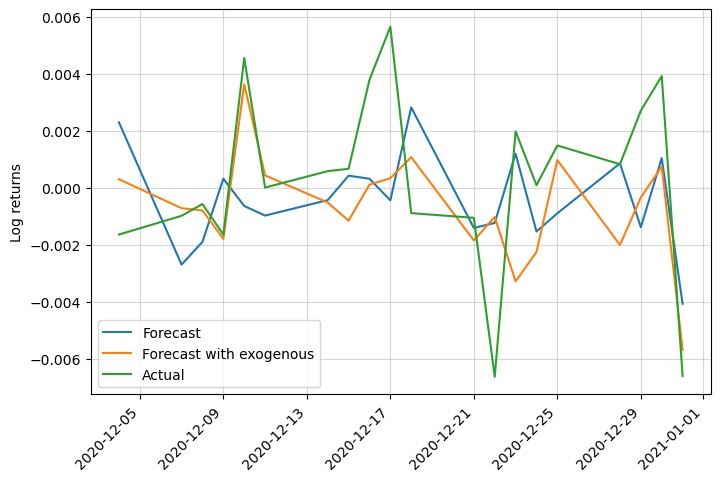

In [22]:
# Transform predictions list to dataframe
y_pred_xgb = pd.DataFrame(y_pred, columns=['forecast'], index=y_test.index)
y_pred_xgb_eur = pd.DataFrame(y_pred_eur, columns=['forecast'], index=y_test.index)

# Plot predictions and test set
plt.figure(figsize=(8,5))
plt.plot(y_pred_xgb_eur.iloc[-20:])
plt.plot(y_pred_xgb.iloc[-20:])
plt.plot(y_test.iloc[-20:])
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.5)
plt.ylabel('Log returns')
plt.legend(['Forecast', 'Forecast with exogenous', 'Actual'])
plt.show()

We can see that by adding the other pairs as exogneous variables the model slightly increases its performance. 

### Visualizing prices

So far we have worked with the log returns, but we want to see how the prices behave. We need to invert the changes made. 

This is the formula we will use:

In [23]:
import datetime

# Get previous day's price
prices_yesterday = df.loc[y_test.index[0] - datetime.timedelta(1): ,'EUR/USD'].shift(1).dropna()

# XGBoost forecasted prices
y_pred_prices_xgb_eur = prices_yesterday * np.exp(y_pred_xgb_eur.forecast)
y_pred_prices_xgb = prices_yesterday * np.exp(y_pred_xgb.forecast)

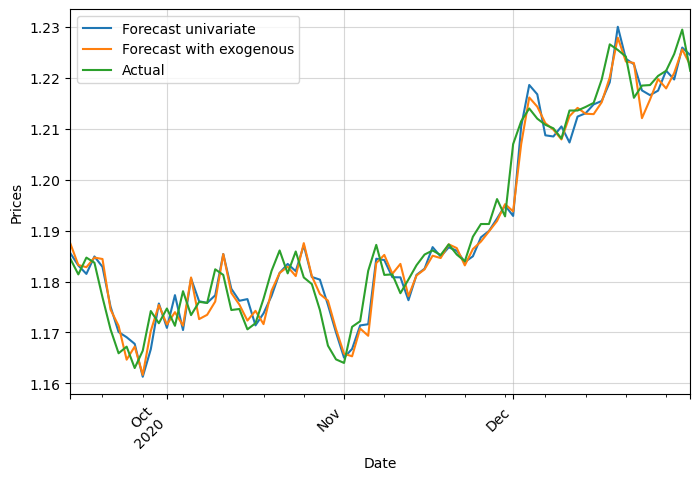

In [24]:
plt.figure(figsize=(8,5))
y_pred_prices_xgb_eur.plot()
y_pred_prices_xgb.plot()
df.loc[y_test.index,'EUR/USD'].plot()
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.5)
plt.ylabel('Prices')
plt.legend(['Forecast univariate', 'Forecast with exogenous', 'Actual'])
plt.show()

It looks alright. Let's zoom in to appreciate it better:

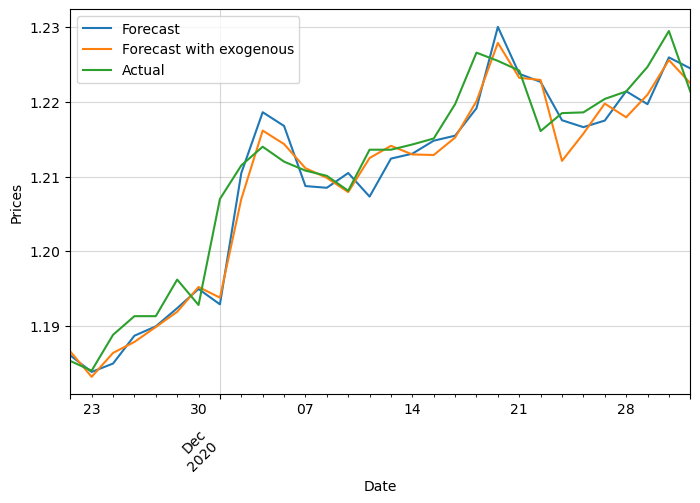

In [25]:
plt.figure(figsize=(8,5))
y_pred_prices_xgb_eur.iloc[-30:].plot()
y_pred_prices_xgb.iloc[-30:].plot()
df.loc[y_test.index,'EUR/USD'].iloc[-30:].plot()
plt.legend(['forecast', 'actual'])
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.5)
plt.ylabel('Prices')
plt.legend(['Forecast', 'Forecast with exogenous', 'Actual'])
plt.show()

This was a univariate example in which we predicted the price of one Forex pair (EUR/USD) by using exogenous variables like other pairs. But what if we wanted to use multiple pairs at once? That would be a multivariate problem. 

### Univariate with additional exogenous variables

Similarly, we can add additional variables like details about the date, average of prices during last week, or even technical indicators used in Forex trading.

#### Temporal data

The features with more potential to be relevant to our model are the day of the week, especially if it is weekend or not, and the month of the year.

In [26]:
# Calculate the day of the week
list_day = df_supervised.index.dayofweek
df_day = pd.DataFrame(list_day, columns=['day_of_week'], index=df_supervised.index)

# Calculate the month of the year
list_month = df_supervised.index.month
df_month = pd.DataFrame(list_month, columns=['month'], index=df_supervised.index)

# Merge it together
df_temp = pd.concat((df_day, df_month), axis=1)
df_temp

,day_of_week,month
2018-01-11,3,1
2018-01-12,4,1
2018-01-15,0,1
2018-01-16,1,1
2018-01-17,2,1
...,...,...
2020-12-25,4,12
2020-12-28,0,12
2020-12-29,1,12
2020-12-30,2,12


### Mean

We could also add some information about the previous week, one possibility is the average return.

In [27]:
df_logret_mean = df_logret.shift(1).rolling(7).mean().dropna()
df_logret_mean.columns = ['weekly mean ' + pair for pair in df_logret_mean.columns]
df_logret_mean

,weekly mean EUR/USD,weekly mean GBP/USD,weekly mean AUD/USD,weekly mean JPY/USD,weekly mean CHF/USD,weekly mean CAD/USD
Date,,,,,,
2018-01-11,-0.000751,0.000042,0.000329,0.001555,-0.000556,-0.000023
2018-01-12,-0.000320,-0.000527,0.001109,0.001342,-0.000631,-0.000068
2018-01-15,0.002042,0.002234,0.001397,0.001866,0.001307,0.000160
2018-01-16,0.002290,0.002497,0.000887,0.002828,0.001696,0.000665
2018-01-17,0.002717,0.002318,0.000887,0.003362,0.002304,-0.000299
...,...,...,...,...,...,...
2020-12-25,0.000411,0.000994,0.000528,0.000041,-0.000804,-0.001967
2020-12-28,0.000082,0.000433,0.000792,0.000000,-0.000547,-0.001417
2020-12-29,-0.000607,-0.001406,0.000378,-0.000939,-0.000661,-0.001408


### Exponential Moving Average

One of the most common technical indicators are the Exponential Moving Averages (EMA) of 5, 10, 20 and 50 days. Let's simply calculate them and check if the price is above (1) or below (0) this value.

In [28]:
def EMA(df:pd.Series, period:int, alpha=None):
    """
    Calculate Exponential Moving Average (EMA) for a list of prices

    :param prices: List of prices
    :param period: Period for which EMA needs to be calculated
    :param alpha: Smoothing factor (if None, then it's calculated as 2 / (period + 1))
    :return: List of EMA values
    """
    prices = df.values.flatten()
    
    if alpha is None:
        alpha = 2 / (period + 1)

    ema_values = [sum(prices[:period]) / period]  # Start with an SMA value for the first point

    for price in prices[period:]:
        ema_values.append((1 - alpha) * ema_values[-1] + alpha * price)

    ema = [None] * (period - 1) + ema_values
    
    df_ema = pd.DataFrame(ema, index=df.index, columns=[f'EMA_{period}']).dropna()
    
    df_ema_indicator = df.loc[df_ema.index] > df_ema.iloc[:,0]
    df_ema_indicator = df_ema_indicator.to_frame(name=f'EMA_{period}')
    return df_ema_indicator.astype(int)


In [29]:
df_ema = pd.DataFrame()
for n_days in [5, 10, 20, 50]:
    df_ema_n = EMA(df['EUR/USD'], n_days)
    df_ema = pd.concat((df_ema, df_ema_n), axis=1)
df_ema.dropna(inplace=True)

In [30]:
df_ema

,EMA_5,EMA_10,EMA_20,EMA_50
Date,,,,
2018-03-09,0,0.0,0.0,1.0
2018-03-12,1,1.0,1.0,1.0
2018-03-13,1,1.0,1.0,1.0
2018-03-14,1,1.0,1.0,1.0
2018-03-15,0,0.0,0.0,1.0
...,...,...,...,...
2020-12-25,1,1.0,1.0,1.0
2020-12-28,1,1.0,1.0,1.0
2020-12-29,1,1.0,1.0,1.0


### Simple Moving Average

We can do the same with the Simple Moving Average or SMA:

In [31]:
def SMA(df:pd.Series, period:int):
    """
    Calculate Simple Moving Average (SMA) for a list of prices

    :param prices: List of prices
    :param period: Period for which SMA needs to be calculated
    :return: List of SMA values
    """
    prices = df.values.flatten()
    
    sma_values = []
    for i in range(len(prices)):
        if i+1 < period:
            sma_values.append(None)
        else:
            sma_values.append(sum(prices[i+1-period:i+1]) / period)
            
    
    df_sma = pd.DataFrame(sma_values, index=df.index, columns=[f'SMA_{period}']).dropna()
    
    df_sma_indicator = df.loc[df_sma.index] > df_sma.iloc[:,0]
    df_sma_indicator = df_sma_indicator.to_frame(name=f'SMA_{period}')
    return df_sma_indicator.astype(int)        
            
            
    return sma_values

In [32]:
df_sma = pd.DataFrame()
for n_days in [5, 10, 20, 50]:
    df_sma_n = SMA(df['EUR/USD'], n_days)
    df_sma = pd.concat((df_sma, df_sma_n), axis=1)
    
df_sma.dropna(inplace=True)

In [33]:
df_sma

,SMA_5,SMA_10,SMA_20,SMA_50
Date,,,,
2018-03-09,0,0.0,0.0,1.0
2018-03-12,0,1.0,0.0,1.0
2018-03-13,1,1.0,1.0,1.0
2018-03-14,1,1.0,1.0,1.0
2018-03-15,0,0.0,0.0,1.0
...,...,...,...,...
2020-12-25,1,1.0,1.0,1.0
2020-12-28,1,1.0,1.0,1.0
2020-12-29,1,1.0,1.0,1.0


### Merge

In [34]:
df_supervised_exo = pd.concat((df_temp, df_ema, df_sma, df_logret_mean, df_supervised), axis=1).dropna()
df_supervised_exo

,day_of_week,month,EMA_5,EMA_10,EMA_20,EMA_50,SMA_5,SMA_10,SMA_20,SMA_50,...,t-7,t-6,t-5,t-4,t-3,t-2,t-1,target,t-1 (GBP/USD),t-1 (CHF/USD)
2018-03-09,4,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.003111,0.006050,0.003986,0.001541,0.005497,0.000725,-0.008170,-0.000406,-0.006423,-0.008128
2018-03-12,0,3,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.006050,0.003986,0.001541,0.005497,0.000725,-0.008170,-0.000406,0.002191,0.002675,0.000000
2018-03-13,1,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.003986,0.001541,0.005497,0.000725,-0.008170,-0.000406,0.002191,0.004530,0.004035,0.003792
2018-03-14,2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.001541,0.005497,0.000725,-0.008170,-0.000406,0.002191,0.004530,-0.001858,0.004091,0.003806
2018-03-15,3,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.005497,0.000725,-0.008170,-0.000406,0.002191,0.004530,-0.001858,-0.005026,-0.000072,-0.001059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,4,12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.003779,0.005641,-0.000897,-0.001061,-0.006639,0.001972,0.000082,0.001476,0.004659,-0.003149
2020-12-28,0,12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.005641,-0.000897,-0.001061,-0.006639,0.001972,0.000082,0.001476,0.000819,-0.000517,0.001911
2020-12-29,1,12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.000897,-0.001061,-0.006639,0.001972,0.000082,0.001476,0.000819,0.002698,-0.007334,0.000563
2020-12-30,2,12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.001061,-0.006639,0.001972,0.000082,0.001476,0.000819,0.002698,0.003912,0.003785,0.004626


In [35]:
df_train_exo = df_supervised_exo.iloc[:n_train]
df_test_exo = df_supervised_exo.iloc[n_train:]

In [37]:
df_train_exo

,day_of_week,month,EMA_5,EMA_10,EMA_20,EMA_50,SMA_5,SMA_10,SMA_20,SMA_50,...,t-7,t-6,t-5,t-4,t-3,t-2,t-1,target,t-1 (GBP/USD),t-1 (CHF/USD)
2018-03-09,4,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.003111,0.006050,0.003986,0.001541,0.005497,0.000725,-0.008170,-0.000406,-0.006423,-0.008128
2018-03-12,0,3,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.006050,0.003986,0.001541,0.005497,0.000725,-0.008170,-0.000406,0.002191,0.002675,0.000000
2018-03-13,1,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.003986,0.001541,0.005497,0.000725,-0.008170,-0.000406,0.002191,0.004530,0.004035,0.003792
2018-03-14,2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.001541,0.005497,0.000725,-0.008170,-0.000406,0.002191,0.004530,-0.001858,0.004091,0.003806
2018-03-15,3,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.005497,0.000725,-0.008170,-0.000406,0.002191,0.004530,-0.001858,-0.005026,-0.000072,-0.001059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,2,11,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.004310,-0.001102,-0.004333,-0.005978,-0.002316,-0.000601,0.006081,0.000939,0.011244,0.007649
2020-11-05,3,11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.001102,-0.004333,-0.005978,-0.002316,-0.000601,0.006081,0.000939,0.008410,-0.005606,-0.000768
2020-11-06,4,11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.004333,-0.005978,-0.002316,-0.000601,0.006081,0.000939,0.008410,0.004305,0.012018,0.009249
2020-11-09,0,11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.005978,-0.002316,-0.000601,0.006081,0.000939,0.008410,0.004305,-0.004982,0.001065,0.003879


We also need to split the features from the target

In [38]:
X_train_exo = df_train_exo.drop(columns=['target'])
y_train_exo = df_train_exo['target']

X_test_exo = df_test_exo.drop(columns=['target'])
y_test_exo = df_test_exo['target']

In [39]:
import xgboost as xgb

# Convert the datasets into DMatrix
dtrain_exo = xgb.DMatrix(X_train_exo, label=y_train_exo)
dtest_exo = xgb.DMatrix(X_test_exo)

# Set XGBoost parameters
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror'
}

# Number of boosting rounds
num_round = 500

# Train the model
bst = xgb.train(param, dtrain_exo, num_round)

# Predict the target for the test set
y_pred_exo = bst.predict(dtest_exo)

# Calculate and print the RMSE
rmse = mean_squared_error(y_test_exo, y_pred_exo, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.0029070176392230443


Let's visualize the prediction:

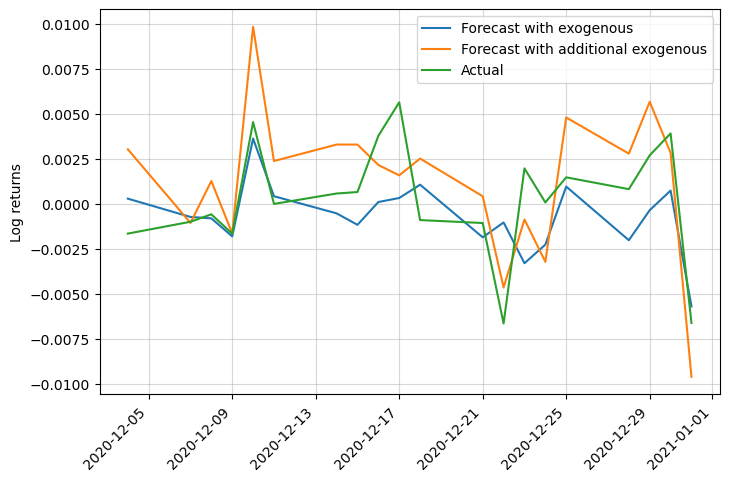

In [40]:
# Transform predictions list to dataframe
y_pred_xgb = pd.DataFrame(y_pred, columns=['forecast'], index=y_test.index)
y_pred_xgb_exo = pd.DataFrame(y_pred_exo, columns=['forecast'], index=y_test_exo.index)

# Plot predictions and test set
plt.figure(figsize=(8,5))
plt.plot(y_pred_xgb.iloc[-20:])
plt.plot(y_pred_xgb_exo.iloc[-20:])
plt.plot(y_test.iloc[-20:])
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.5)
plt.ylabel('Log returns')
plt.legend(['Forecast with exogenous', 'Forecast with additional exogenous', 'Actual'])
plt.show()

We can see that by adding the other pairs as exogneous variables the model slightly increases its performance. 

### Visualizing prices

So far we have worked with the log returns, but we want to see how the prices behave. We need to invert the changes made. 

This is the formula we will use:

In [41]:
import datetime

# Get previous day's price
prices_yesterday = df.loc[y_test.index[0] - datetime.timedelta(1): ,'EUR/USD'].shift(1).dropna()

# XGBoost forecasted prices
y_pred_prices_xgb_exo = prices_yesterday * np.exp(y_pred_xgb_exo.forecast)

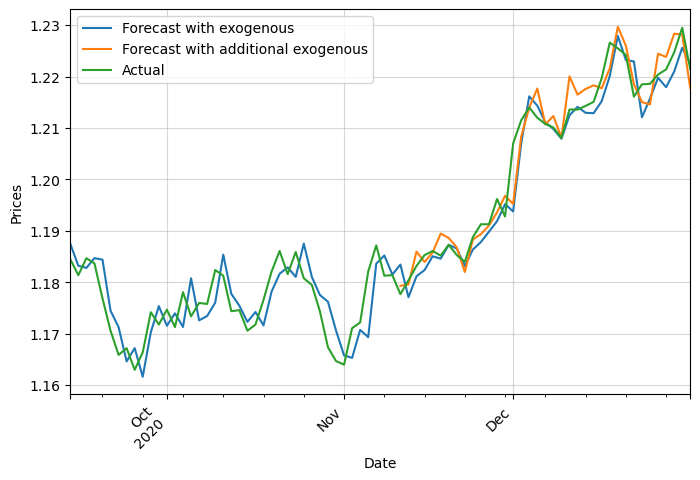

In [42]:
plt.figure(figsize=(8,5))
y_pred_prices_xgb.plot()
y_pred_prices_xgb_exo.plot()
df.loc[y_test.index,'EUR/USD'].plot()
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.5)
plt.ylabel('Prices')
plt.legend(['Forecast with exogenous', 'Forecast with additional exogenous', 'Actual'])
plt.show()

It looks alright. Let's zoom in to appreciate it better:

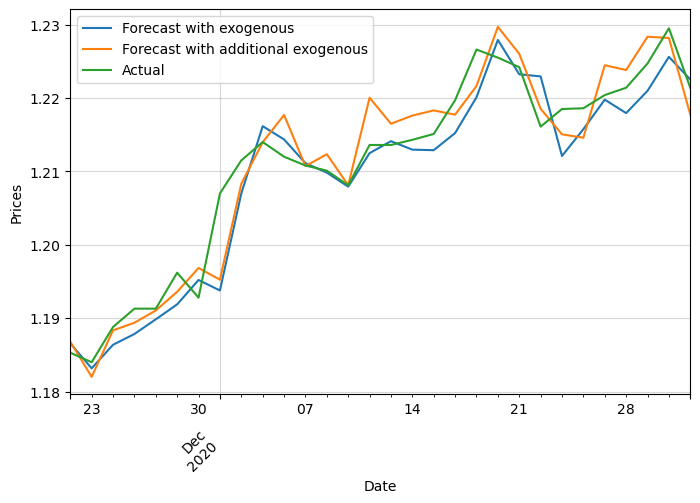

In [43]:
plt.figure(figsize=(8,5))
y_pred_prices_xgb.iloc[-30:].plot()
y_pred_prices_xgb_exo.iloc[-30:].plot()
df.loc[y_test.index,'EUR/USD'].iloc[-30:].plot()
plt.legend(['forecast', 'actual'])
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.5)
plt.ylabel('Prices')
plt.legend(['Forecast with exogenous', 'Forecast with additional exogenous', 'Actual'])
plt.show()

## Multivariate problem

XGBoost does not support multivariate models. We would need to train one model per pair. For this we could use a simple Neural Network.

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [48]:
df_logret

,EUR/USD,GBP/USD,AUD/USD,JPY/USD,CHF/USD,CAD/USD
Date,,,,,,
2018-01-02,0.004072,0.006275,0.003198,0.003201,0.002980,0.002554
2018-01-03,-0.003739,-0.005313,0.000766,-0.001779,-0.005645,-0.001597
2018-01-04,0.004485,0.002734,0.003567,-0.002220,0.002562,0.003677
2018-01-05,-0.003154,0.001327,0.000000,-0.002923,-0.000615,0.006266
2018-01-08,-0.005251,-0.000221,-0.002929,-0.000088,-0.001946,-0.000967
...,...,...,...,...,...,...
2020-12-25,0.001476,-0.000517,0.001844,0.001449,0.001911,0.000311
2020-12-28,0.000819,-0.007334,-0.002899,-0.002895,0.000563,0.001867
2020-12-29,0.002698,0.003785,0.000000,0.002122,0.004626,0.002182


In [49]:
df_supervised_multi = pd.DataFrame()

for pair in df_logret.columns:
    df_supervised_x = reframe_to_supervised(df_logret[pair], window_size=7, target=True, target_name=True)
    df_supervised_multi = pd.concat((df_supervised_multi, df_supervised_x), axis=1).dropna()

In [50]:
df_train_multi = df_supervised_multi.iloc[:n_train]
df_test_multi = df_supervised_multi.iloc[n_train:]

In [51]:
df_train_multi

,t-7 (EUR/USD),t-6 (EUR/USD),t-5 (EUR/USD),t-4 (EUR/USD),t-3 (EUR/USD),t-2 (EUR/USD),t-1 (EUR/USD),target (EUR/USD),t-7 (GBP/USD),t-6 (GBP/USD),...,t-1 (CHF/USD),target (CHF/USD),t-7 (CAD/USD),t-6 (CAD/USD),t-5 (CAD/USD),t-4 (CAD/USD),t-3 (CAD/USD),t-2 (CAD/USD),t-1 (CAD/USD),target (CAD/USD)
2018-01-11,0.004072,-0.003739,0.004485,-0.003154,-0.005251,-0.002510,0.000837,0.007090,0.006275,-0.005313,...,0.005200,0.002456,0.002554,-0.001597,0.003677,0.006266,-0.000967,-0.003456,-0.006637,0.002234
2018-01-12,-0.003739,0.004485,-0.003154,-0.005251,-0.002510,0.000837,0.007090,0.012800,-0.005313,0.002734,...,0.002456,0.007921,-0.001597,0.003677,0.006266,-0.000967,-0.003456,-0.006637,0.002234,0.000000
2018-01-15,0.004485,-0.003154,-0.005251,-0.002510,0.000837,0.007090,0.012800,0.006217,0.002734,0.001327,...,0.007921,0.005281,0.003677,0.006266,-0.000967,-0.003456,-0.006637,0.002234,0.000000,0.007215
2018-01-16,-0.003154,-0.005251,-0.002510,0.000837,0.007090,0.012800,0.006217,-0.000163,0.001327,-0.000221,...,0.005281,0.003641,0.006266,-0.000967,-0.003456,-0.006637,0.002234,0.000000,0.007215,-0.000483
2018-01-17,-0.005251,-0.002510,0.000837,0.007090,0.012800,0.006217,-0.000163,-0.006136,-0.000221,-0.002066,...,0.003641,-0.006337,-0.000967,-0.003456,-0.006637,0.002234,0.000000,0.007215,-0.000483,-0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,0.006913,0.002769,-0.002181,-0.004797,-0.000338,-0.000929,-0.001776,-0.003221,0.011376,0.001497,...,-0.003062,-0.001527,0.001983,0.003978,-0.001302,0.001532,-0.006420,0.004964,-0.002676,-0.010331
2020-09-09,0.002769,-0.002181,-0.004797,-0.000338,-0.000929,-0.001776,-0.003221,0.001951,0.001497,0.000897,...,-0.001527,0.005466,0.003978,-0.001302,0.001532,-0.006420,0.004964,-0.002676,-0.010331,0.006901
2020-09-10,-0.002181,-0.004797,-0.000338,-0.000929,-0.001776,-0.003221,0.001951,0.000932,0.000897,-0.002170,...,0.005466,0.002085,-0.001302,0.001532,-0.006420,0.004964,-0.002676,-0.010331,0.006901,-0.003722
2020-09-11,-0.004797,-0.000338,-0.000929,-0.001776,-0.003221,0.001951,0.000932,0.002705,-0.002170,-0.005407,...,0.002085,0.001979,0.001532,-0.006420,0.004964,-0.002676,-0.010331,0.006901,-0.003722,0.000000


We also need to split the features from the target

In [52]:
target_columns = [col for col in df_train_multi.columns if "target" in col]

X_train_multi = df_train_multi.drop(columns=target_columns)
y_train_multi = df_train_multi[target_columns]

X_test_multi = df_test_multi.drop(columns=target_columns)
y_test_multi = df_test_multi[target_columns]

In [53]:
input_dim = X_train_multi.shape[1]
output_dim = y_train_multi.shape[1]

Create a neural network model using Keras' Sequential API. Here, we'll use a simple feedforward neural network (also known as a multi-layer perceptron).

In [54]:
# Initialize the model
model = Sequential()

# Add layers
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

# Output layer with 3 output variables
model.add(Dense(output_dim, activation='linear'))



Compile the model, specifying the optimizer, loss function, and metrics to track.

In [56]:
from tensorflow.keras.optimizers import Adam
# optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

We will train a basic version of this model first.

In [63]:
history = model.fit(X_train_multi, y_train_multi, 
                    epochs=1000, batch_size=32, verbose=1)

Epoch 1/1000
22/22 [==============================] - 0s 3ms/step - loss: 1.4644e-07 - mae: 3.0155e-04
Epoch 2/1000
22/22 [==============================] - 0s 3ms/step - loss: 1.3419e-07 - mae: 2.8536e-04
Epoch 3/1000
22/22 [==============================] - 0s 3ms/step - loss: 1.3548e-07 - mae: 2.8733e-04
Epoch 4/1000
22/22 [==============================] - 0s 3ms/step - loss: 1.6491e-07 - mae: 3.1609e-04
Epoch 5/1000
22/22 [==============================] - 0s 3ms/step - loss: 2.2787e-07 - mae: 3.7347e-04
Epoch 6/1000
22/22 [==============================] - 0s 2ms/step - loss: 4.2724e-07 - mae: 5.0928e-04
Epoch 7/1000
22/22 [==============================] - 0s 2ms/step - loss: 5.0165e-07 - mae: 5.5865e-04
Epoch 8/1000
22/22 [==============================] - 0s 2ms/step - loss: 5.6118e-07 - mae: 5.8409e-04
Epoch 9/1000
22/22 [==============================] - 0s 2ms/step - loss: 3.9634e-07 - mae: 4.8966e-04
Epoch 10/1000
22/22 [==============================] - 0s 2ms/step - loss

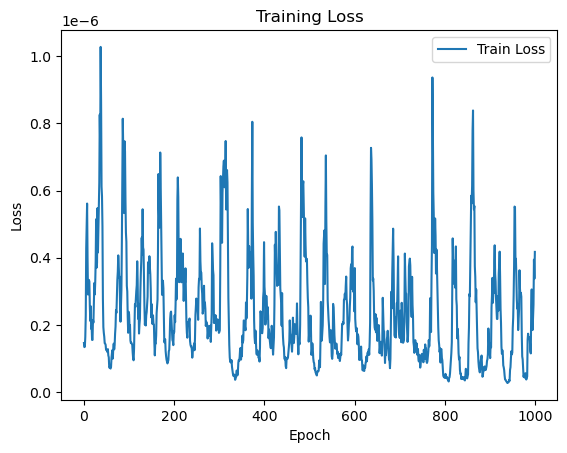

In [71]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['Train Loss'])
plt.show()

Now we can add more advanced functionalities like early stopping or real time losses plots

In [72]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=30, verbose=1, mode='auto')

In [73]:
from IPython.display import clear_output

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        
        clear_output(wait=True)
        plt.clf()  # Clear the current figure (prevents multiple plots)
        plt.plot(self.losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend(['Train Loss'])
        plt.draw()
        plt.pause(0.001)


Train the model using the sample data.

In [74]:
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

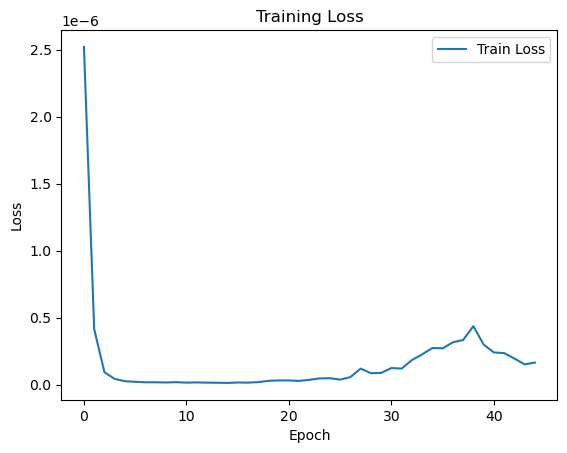

22/22 [==============================] - 0s 19ms/step - loss: 1.6489e-07 - mae: 3.2028e-04
Epoch 45: early stopping


In [75]:
plot_losses = PlotLosses()
history = model.fit(X_train_multi, y_train_multi, epochs=1000, batch_size=32, verbose=1, callbacks=[plot_losses, early_stopping])

Finally, we can control the performance of our model by checking how the training loss compares with the validation loss.

In [76]:
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

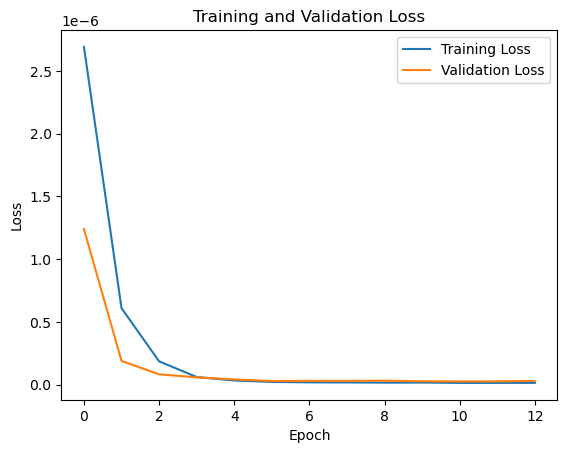

18/18 [==============================] - 0s 28ms/step - loss: 1.3055e-08 - mae: 8.9382e-05 - val_loss: 2.8857e-08 - val_mae: 1.2882e-04
Epoch 14/1000
 1/18 [>.............................] - ETA: 0s - loss: 1.7853e-08 - mae: 1.0632e-04

In [ ]:
# Callback for plotting losses
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs_loss = []
        self.epochs_val_loss = []
        self.fig = plt.figure()
        
    def on_epoch_end(self, epoch, logs={}):
        self.epochs_loss.append(logs.get('loss'))
        self.epochs_val_loss.append(logs.get('val_loss'))  # Capture validation loss
        clear_output(wait=True)
        plt.plot(self.epochs_loss, label='Training Loss')
        plt.plot(self.epochs_val_loss, label='Validation Loss')  # Plot validation loss
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.draw()
        plt.pause(0.001)

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min')

# Train the model
plot_losses = PlotLosses()
history = model.fit(X_train_multi, y_train_multi,
                    epochs=1000,
                    batch_size=32,
                    verbose=1,
                    callbacks=[plot_losses, early_stopping],
                    validation_split=0.2)  # 20% of the data will be used as a validation set

In [ ]:
# Make predictions
predictions = model.predict(X_test_multi)

In [ ]:
df_predictions = pd.DataFrame(predictions, index=y_test_multi.index, columns=y_test_multi.columns)
df_predictions

In [ ]:
for i, pair in enumerate(df_logret.columns):
    df_predictions.iloc[-30:,i].plot(figsize=(8,5))
    y_test_multi.iloc[-30:,i].plot()
    plt.legend(['Forecast', 'Actual'])
    plt.grid(alpha=0.3)
    plt.title(pair)
    plt.xlabel('Date')
    plt.ylabel('Log returns')
    plt.show()

In [ ]:
import datetime

for pair in df_logret.columns:
    # Get previous day's price
    prices_yesterday = df.loc[y_test_multi.index[0] - datetime.timedelta(1):, f'{pair}'].shift(1).dropna()

    # XGBoost forecasted prices
    y_pred_prices_multi = prices_yesterday * np.exp(df_predictions[f'target ({pair})'])

    plt.figure(figsize=(8,5))
    y_pred_prices_multi.iloc[-30:].plot()
    df.loc[y_test_multi.index, f'{pair}'].iloc[-30:].plot()
    plt.legend(['forecast', 'actual'])
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.5)
    plt.ylabel('Prices')
    plt.legend(['Forecast', 'Actual'])
    plt.title(pair)
    plt.show()

In [ ]:
plt.figure(figsize=(8,5))
y_pred_prices_xgb.iloc[-30:].plot()
df.loc[y_test.index,'EUR/USD'].iloc[-30:].plot()
plt.legend(['forecast', 'actual'])
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.5)
plt.ylabel('Prices')
plt.legend(['Forecast', 'Forecast with exogenous', 'Actual'])
plt.show()

We can see that it is not great, as it seems like both of them are just replicating the last price with a minimal adjustment. We should add more information with additional features:
* Day of the week and month
* Mean return during a certain period
* Technical indications such as Moving Average
* Exogenous variables like other Forex pairs